# Outline: Filament BAO

## 1. Read SDSS Data
- Load the SDSS dataset.
- Perform initial inspection and data cleaning if necessary.

## 2. Create Randoms
- Generate a set of random points within the survey volume.
- Ensure a uniform distribution for proper statistical analysis.

## 3. Assign Redshifts to Randoms
- Assign redshift values to the random catalog.
- Match the redshift distribution of the SDSS data.

## 4. Calculate ξ(s)
- Compute the two-point correlation function in redshift space.
- Use pair-counting techniques to measure clustering.

## 5. Calculate ξ(r)
- Compute the two-point correlation function in real space.
- Account for redshift-space distortions to recover the real-space clustering signal.


### 1) Read SDSS and 2) Create Randoms and 3) Assign redshift to randoms

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_parabola(data, vmin, vmax, num_points=10000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
# Load galaxy data
zmin, zmax = 0.05, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]
ra = cat_sdss['ra'].values  # Right Ascension
dec = cat_sdss['dec'].values  # Declination

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)
nrand = 70 # Times the size of the data (around 10% is left after mask)

# Total number of pixels in the map
npix = hp.nside2npix(nside)

# Initialize a mask array (1 = valid, 0 = invalid)
mask = np.zeros(npix, dtype=int)

# Convert RA, Dec to Healpix indices
theta = np.radians(90 - dec)  # Declination to colatitude
phi = np.radians(ra)          # Right Ascension to longitude
pixels = hp.ang2pix(nside, theta, phi)

# Mark these pixels as valid
mask[pixels] = 1

num_randoms = len(ra)*nrand  # Number of random points

# Generate uniform random RA, Dec
ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
u = np.random.uniform(-1, 1, num_randoms)
dec_random_rad = np.arcsin(u)
dec_random = np.rad2deg(dec_random_rad)
#dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

# Convert RA, Dec to Healpix indices
theta_random = np.radians(90 - dec_random)
phi_random = np.radians(ra_random)
random_pixels = hp.ang2pix(nside, theta_random, phi_random)

# Apply the mask
valid_indices = mask[random_pixels] == 1
ra_random = ra_random[valid_indices]
dec_random = dec_random[valid_indices]

# Read redshift distribution and apply to randoms
# Build the inverse CDF from a smoothed KDE fit
cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(cat_sdss['red'], zmin, zmax)

# Generate random redshifts
u = np.random.uniform(0, 1, len(ra_random))
red_random = cdf_inv_z(u)

random_data = pd.DataFrame({
    'ra': ra_random,
    'dec': dec_random,
    'red': red_random
})

print(len(cat_sdss))
print(len(random_data))

random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)


/home/federico/miniconda3/envs/nbodykit-env/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


327243
4014522


### 3.1 Show angular and redshift distribution

/home/federico/miniconda3/envs/nbodykit-env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


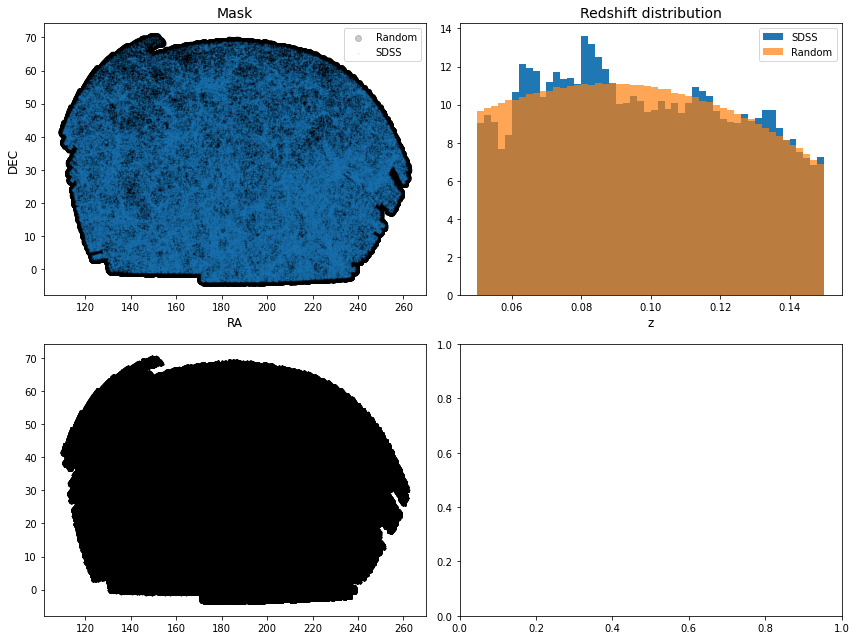

In [6]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=False)  # 1 row, 2 columns

# Plot left
axes[0,0].scatter(random_data['ra'],random_data['dec'],color='k',alpha=.2,label='Random')
axes[0,0].scatter(cat_sdss['ra'], cat_sdss['dec'],color='C00',s=1,alpha=.1,label='SDSS')

# Plot for just randoms
axes[1,0].scatter(random_data['ra'],random_data['dec'],color='k',alpha=1,s=1,label='Random')


# Plot right
axes[0,1].hist(cat_sdss['red'],bins=50, color='C00', density=True, histtype='stepfilled', label='SDSS')
axes[0,1].hist(random_data['red'],bins=50, color='C01', density=True, histtype='stepfilled', alpha=0.7, label='Random')

# Customize each subplot
axes[0,0].set_title("Mask", fontsize=14)
axes[0,0].set_xlabel("RA", fontsize=12)
axes[0,0].set_ylabel("DEC", fontsize=12)
axes[0,0].tick_params(axis='both', labelsize=10)

axes[0,0].legend()

axes[0,1].set_title("Redshift distribution", fontsize=14)
axes[0,1].set_xlabel("z", fontsize=12)
axes[0,1].tick_params(axis='both', labelsize=10)

axes[0,1].legend()

# Adjust layout for readability
plt.tight_layout()

# Save or show the figure
#plt.savefig('1x2_plot_layout.png', dpi=300)  # Save as a high-res image
plt.show()


### 1.1) Show filament galaxies and non-filament galaxies

/tmp/ipykernel_120488/3683414789.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


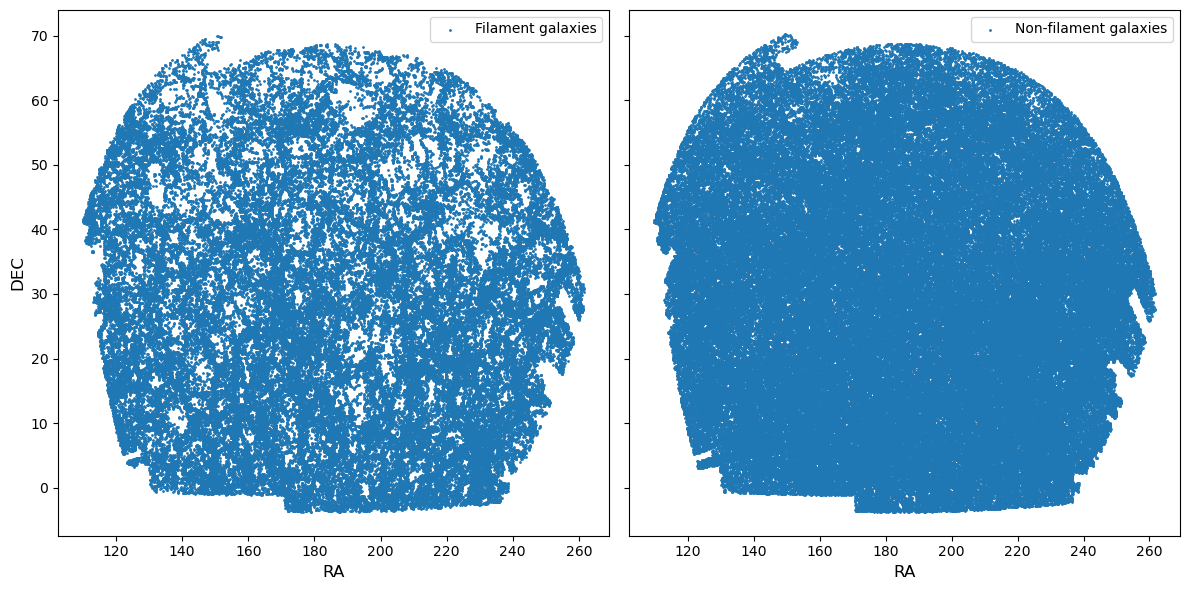

114783
199629


In [2]:
import matplotlib.pyplot as plt

filgxs = cat_sdss[cat_sdss['dist_fil']<=3.]

nonfilgxs = cat_sdss[cat_sdss['dist_fil']>8.25]

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # 1 row, 2 columns

# Plot left
axes[0].scatter(filgxs['ra'],filgxs['dec'],color='C00',s=1,label='Filament galaxies')

# Plot right
axes[1].scatter(nonfilgxs['ra'],nonfilgxs['dec'],color='C00',s=1,label='Non-filament galaxies')

# Customize each subplot
#axes[0].set_title("Mask", fontsize=14)
axes[0].set_xlabel("RA", fontsize=12)
axes[0].set_ylabel("DEC", fontsize=12)
axes[0].tick_params(axis='both', labelsize=10)

axes[0].legend()

#axes[1].set_title("Redshift distribution", fontsize=14)
axes[1].set_xlabel("RA", fontsize=12)
axes[1].tick_params(axis='both', labelsize=10)

axes[1].legend()

# Adjust layout for readability
plt.tight_layout()

# Save or show the figure
#plt.savefig('1x2_plot_layout.png', dpi=300)  # Save as a high-res image
plt.show()

print(len(filgxs))
print(len(nonfilgxs))

114783


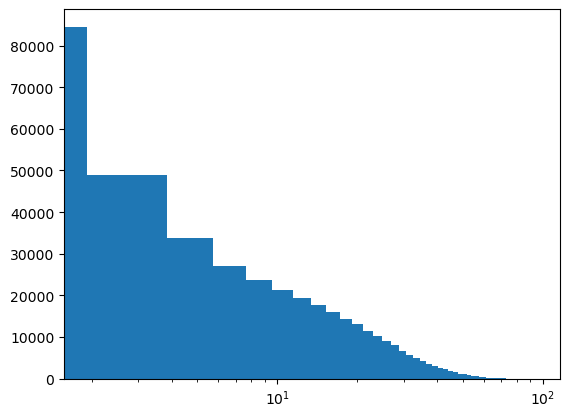

In [6]:
plt.hist(cat_sdss['dist_fil'],bins=50)

print(len(cat_sdss[cat_sdss['dist_fil']<3.]))

plt.xscale('log')
plt.show()